In [1]:
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate

import os
import numpy as np
import cv2
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import to_categorical

# Define the paths
image_path = '/home/hosnydiab/code/hosnydiab/data-project-solarpanel/AerialImageDataset/resized_images/train/images/'
mask_path = '/home/hosnydiab/code/hosnydiab/data-project-solarpanel/AerialImageDataset/resized_images/train/gt'
test_path = '/home/hosnydiab/code/hosnydiab/data-project-solarpanel/AerialImageDataset/resized_images/test/images/'

2023-05-29 14:33:00.871689: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-29 14:33:01.009171: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-05-29 14:33:01.009200: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-05-29 14:33:01.038660: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-05-29 14:33:02.261317: W tensorflow/stream_executor/platform/de

In [2]:
# Define the UNet class
class UNet:
    def __init__(self, input_shape=(512, 512, 3)):
        self.input_shape = input_shape
        self.model = self.build_model()

    # Rest of the UNet class code here...
    def encoder(self, inputs):
        conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
        conv1 = BatchNormalization()(conv1)
        conv1 = Dropout(0.1)(conv1)
        pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

        conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
        conv2 = BatchNormalization()(conv2)
        conv2 = Dropout(0.1)(conv2)
        pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

        return conv1, conv2, pool2

    def decoder(self, conv1, conv2, encoded):
        up1 = UpSampling2D(size=(2, 2))(encoded)
        merge1 = Concatenate(axis=3)([conv2, up1])
        conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(merge1)
        conv3 = BatchNormalization()(conv3)
        conv3 = Dropout(0.1)(conv3)

        up2 = UpSampling2D(size=(2, 2))(conv3)
        merge2 = Concatenate(axis=3)([conv1, up2])
        conv4 = Conv2D(64, (1, 3), activation='relu', padding='same')(merge2)
        conv4 = BatchNormalization()(conv4)
        conv4 = Dropout(0.1)(conv4)

        return conv4

    def build_model(self):
        inputs = Input(self.input_shape)
        conv1, conv2, encoded = self.encoder(inputs)
        decoded = self.decoder(conv1, conv2, encoded)
        outputs = Conv2D(1, (1, 1), activation='sigmoid')(decoded)
        return Model(inputs=inputs, outputs=outputs)

    def train(self, x, y, epochs=1, batch_size=32, validation_split=0.1, verbose=1):
        self.model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
        lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.00001, verbose=1)
        early_stopper = EarlyStopping(monitor='val_loss', patience=2, verbose=1, restore_best_weights=True)
        self.model.fit(x, y, epochs=epochs, batch_size=batch_size, validation_split=validation_split,
                       callbacks=[lr_reducer, early_stopper])

    def predict(self, x):
        return self.model.predict(x)

In [3]:
# Define the area names
areas = ['austin', 'chicago', 'kitsap', 'tyrol-w', 'vienna']

# Define a function to load and preprocess images
def load_images(image_dir, mask_dir=None):
    images = []
    masks = []
    
    if mask_dir is None:
        for area in areas:
            area_image_dir = os.path.join(image_dir, area)
            for filename in os.listdir(area_image_dir):
                if filename.endswith('.tif'):
                    image = cv2.imread(os.path.join(area_image_dir, filename))
                    image = cv2.resize(image, (512, 512))  # Resize image to desired input shape
                    image = img_to_array(image) / 255.0  # Normalize image values between 0 and 1
                    images.append(image)
    else:
        for area in areas:
            area_image_dir = os.path.join(image_dir, area)
            area_mask_dir = os.path.join(mask_dir, area)
            for filename in os.listdir(area_image_dir):
                if filename.endswith('.tif'):
                    image = cv2.imread(os.path.join(area_image_dir, filename))
                    image = cv2.resize(image, (512, 512))  # Resize image to desired input shape
                    image = img_to_array(image) / 255.0  # Normalize image values between 0 and 1
                    images.append(image)
                    
                    mask = cv2.imread(os.path.join(area_mask_dir, filename), cv2.IMREAD_GRAYSCALE)
                    mask = cv2.resize(mask, (512, 512))
                    mask = np.expand_dims(mask, axis=-1)
                    mask = mask / 255.0  # Normalize mask values between 0 and 1
                    masks.append(mask)
    
    if mask_dir:
        return np.array(images), np.array(masks)
    else:
        return np.array(images)

# Load training data
train_images, train_masks = load_images(image_path, mask_path)


# Create an instance of the UNet model
model = UNet()
model.build_model().summary()

2023-05-29 14:33:10.107059: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/hosnydiab/.pyenv/versions/3.8.12/envs/solar_roof_segmentation/lib/python3.8/site-packages/cv2/../../lib64:
2023-05-29 14:33:10.107147: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2023-05-29 14:33:10.107178: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (SLB-J146JN2): /proc/driver/nvidia/version does not exist
2023-05-29 14:33:10.107479: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropri

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_5 (Conv2D)              (None, 512, 512, 64  1792        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_4 (BatchNo  (None, 512, 512, 64  256        ['conv2d_5[0][0]']               
 rmalization)                   )                                                           

In [4]:
# Train the model
model.train(train_images, train_masks, epochs=6, batch_size=64, validation_split=0.1, verbose=1)


Epoch 1/6
3/3 [==============================] - 243s 73s/step - loss: 0.8077 - accuracy: 0.4668 - val_loss: 0.7059 - val_accuracy: 0.1364 - lr: 1.0000e-04
Epoch 2/6
3/3 [==============================] - 240s 73s/step - loss: 0.7513 - accuracy: 0.5155 - val_loss: 0.6953 - val_accuracy: 0.2481 - lr: 1.0000e-04
Epoch 3/6
3/3 [==============================] - 233s 70s/step - loss: 0.7299 - accuracy: 0.5209 - val_loss: 0.6875 - val_accuracy: 0.4034 - lr: 1.0000e-04
Epoch 4/6
3/3 [==============================] - 237s 73s/step - loss: 0.7097 - accuracy: 0.5356 - val_loss: 0.6831 - val_accuracy: 0.4837 - lr: 1.0000e-04
Epoch 5/6
3/3 [==============================] - 233s 71s/step - loss: 0.6958 - accuracy: 0.5462 - val_loss: 0.6796 - val_accuracy: 0.5162 - lr: 1.0000e-04
Epoch 6/6
3/3 [==============================] - 233s 71s/step - loss: 0.6835 - accuracy: 0.5558 - val_loss: 0.6757 - val_accuracy: 0.5204 - lr: 1.0000e-04


In [5]:
# Define the path for test images
test_image_path = '/home/hosnydiab/code/hosnydiab/data-project-solarpanel/AerialImageDataset/resized_images/test/images/'

# Load the test images
test_images = []
test_image_files = os.listdir(test_image_path)
for test_image_file in test_image_files:
    test_image = cv2.imread(os.path.join(test_image_path, test_image_file))
    test_images.append(test_image)

# Convert the test images to numpy array and normalize
test_images = np.array(test_images) / 255.0



In [6]:
# Make predictions on test data
predictions = model.predict(test_images)

# Perform further post-processing or analysis on the predictions
# ...

# Save the predictions or visualize the results
# ...

6/6 [==============================] - 54s 9s/step


In [7]:
# Calculate the average of values for all images
average_value = np.mean(predictions)

# Print the average value
print("Average Value:", average_value)

Average Value: 0.4841184


1/1 [==============================] - 0s 332ms/step


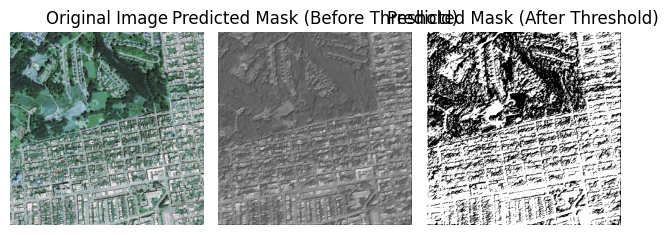

Minimum Value: 0.43972382
Maximum Value: 0.53943694


In [9]:
import random
import matplotlib.pyplot as plt

# Select a random image index
image_index = random.randint(0, len(test_images) - 1)

# Get the corresponding test image and make a prediction
test_image = test_images[image_index]
prediction = model.predict(np.expand_dims(test_image, axis=0))

# Reshape the prediction to remove the batch dimension
prediction = np.squeeze(prediction)

# Calculate the minimum and maximum values of the prediction
min_value = np.min(prediction)
max_value = np.max(prediction)

# Apply threshold to convert to binary mask
threshold = 0.48  # Adjust the threshold value as needed
binary_mask = (prediction >= threshold).astype('float32')

# Plot the original image
plt.subplot(1, 3, 1)
plt.imshow(test_image)
plt.title("Original Image")
plt.axis("off")

# Plot the predicted mask
plt.subplot(1, 3, 2)
plt.imshow(prediction, cmap='gray')
plt.title("Predicted Mask (Before Threshold)")
plt.axis("off")

# Plot the binary mask after applying threshold
plt.subplot(1, 3, 3)
plt.imshow(binary_mask, cmap='gray')
plt.title("Predicted Mask (After Threshold)")
plt.axis("off")

plt.tight_layout()
plt.show()


# Display the minimum and maximum values of the prediction
print("Minimum Value:", min_value)
print("Maximum Value:", max_value)

In [10]:
from tensorflow.keras.applications import VGG19

class UNet2:
    def __init__(self, input_shape=(512, 512, 3)):
        self.input_shape = input_shape
        self.model = self.build_model()

    def encoder(self, inputs):
        # Resize input to match VGG19's minimum input shape
        resized_inputs = tf.image.resize(inputs, (256, 256))  
        
        # Load VGG19 model with pre-trained weights
        base_model = VGG19(include_top=False, weights='imagenet', input_tensor=resized_inputs)
        for layer in base_model.layers:
            layer.trainable = False
        
        # Choose the desired VGG19 layer as the output
        encoder_output = base_model.get_layer('block5_conv4').output  
        
        return base_model, encoder_output

    def decoder(self, base_model, encoder_output):
        up1 = UpSampling2D(size=(2, 2))(encoder_output)
        merge1 = Concatenate(axis=3)([base_model.get_layer('block4_conv4').output, up1])
        conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(merge1)
        conv3 = BatchNormalization()(conv3)
        conv3 = Dropout(0.1)(conv3)

        up2 = UpSampling2D(size=(2, 2))(conv3)
        merge2 = Concatenate(axis=3)([base_model.get_layer('block3_conv4').output, up2])
        conv4 = Conv2D(64, (1, 3), activation='relu', padding='same')(merge2)
        conv4 = BatchNormalization()(conv4)
        conv4 = Dropout(0.1)(conv4)

        return conv4

    def build_model(self):
        inputs = Input(self.input_shape)
        base_model, encoder_output = self.encoder(inputs)
        decoded = self.decoder(base_model, encoder_output)
        outputs = Conv2D(1, (1, 1), activation='sigmoid')(decoded)
        return Model(inputs=inputs, outputs=outputs)

    def train(self, x, y, epochs=1, batch_size=32, validation_split=0.1, verbose=1):
        self.model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
        lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.00001, verbose=1)
        early_stopper = EarlyStopping(monitor='val_loss', patience=2, verbose=1, restore_best_weights=True)
        self.model.fit(x, y, epochs=epochs, batch_size=batch_size, validation_split=validation_split,
                       callbacks=[lr_reducer, early_stopper])

    def predict(self, x):
        return self.model.predict(x)


In [11]:
# Create an instance of the UNet model
model2 = UNet2()
model2.build_model().summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 tf.image.resize_1 (TFOpLambda)  (None, 256, 256, 3)  0          ['input_4[0][0]']                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 256, 256, 64  1792        ['tf.image.resize_1[0][0]']      
                                )                                                                 
                                                                                            

In [12]:
# Resize the masks to match the input size of the updated model
resized_train_masks = tf.image.resize(train_masks, (64, 64))


In [13]:
# Train the model
model2.train(train_images, resized_train_masks, epochs=100, batch_size=100, validation_split=0.1, verbose=1)


Epoch 1/100
2/2 [==============================] - 30s 12s/step - loss: 0.8964 - accuracy: 0.3845 - val_loss: 1.9506 - val_accuracy: 0.2764 - lr: 1.0000e-04
Epoch 2/100
2/2 [==============================] - 28s 12s/step - loss: 0.8525 - accuracy: 0.3880 - val_loss: 1.5151 - val_accuracy: 0.2717 - lr: 1.0000e-04
Epoch 3/100
2/2 [==============================] - 27s 12s/step - loss: 0.8170 - accuracy: 0.3922 - val_loss: 1.2957 - val_accuracy: 0.2660 - lr: 1.0000e-04
Epoch 4/100
2/2 [==============================] - 27s 12s/step - loss: 0.7905 - accuracy: 0.3956 - val_loss: 1.2095 - val_accuracy: 0.2566 - lr: 1.0000e-04
Epoch 5/100
2/2 [==============================] - 27s 12s/step - loss: 0.7708 - accuracy: 0.4002 - val_loss: 1.2044 - val_accuracy: 0.2441 - lr: 1.0000e-04
Epoch 6/100
2/2 [==============================] - 27s 12s/step - loss: 0.7565 - accuracy: 0.4055 - val_loss: 1.2423 - val_accuracy: 0.2322 - lr: 1.0000e-04
Epoch 7/100
2/2 [==============================] - 27s 12s

In [14]:
# # Define the path for test images
# test_image_path = 'AerialImageDataset/resized_images/test/images/'

# # Load the test images
# test_images = []
# test_image_files = os.listdir(test_image_path)
# for test_image_file in test_image_files:
#     test_image = cv2.imread(os.path.join(test_image_path, test_image_file))
#     test_images.append(test_image)

# # Convert the test images to numpy array and normalize
# test_images = np.array(test_images) / 255.0

# Make predictions on test data
predictions2 = model2.predict(test_images)


6/6 [==============================] - 23s 4s/step


In [15]:
# Calculate the average of values for all images
average_value2 = np.mean(predictions2)

# Print the average value
print("Average Value:", average_value2)

Average Value: 0.29917613


1/1 [==============================] - 0s 176ms/step


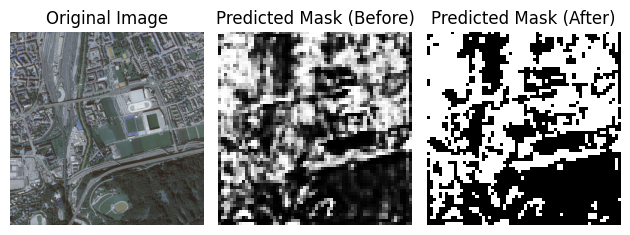

Minimum Value: 1.2404811e-05
Maximum Value: 0.99982214


In [16]:
import random
import matplotlib.pyplot as plt

# Select a random image index
image_index = random.randint(0, len(test_images) - 1)

# Get the corresponding test image and make a prediction
test_image = test_images[image_index]
prediction2 = model2.predict(np.expand_dims(test_image, axis=0))

# Reshape the prediction to remove the batch dimension
prediction2 = np.squeeze(prediction2)

# Calculate the minimum and maximum values of the prediction
min_value = np.min(prediction2)
max_value = np.max(prediction2)

# Apply threshold to convert to binary mask
threshold = 0.3  # Adjust the threshold value as needed
binary_mask2 = (prediction2 >= threshold).astype('float32')

# Plot the original image
plt.subplot(1, 3, 1)
plt.imshow(test_image)
plt.title("Original Image")
plt.axis("off")

# Plot the predicted mask
plt.subplot(1, 3, 2)
plt.imshow(prediction2, cmap='gray')
plt.title("Predicted Mask (Before)")
plt.axis("off")

# Plot the binary mask after applying threshold
plt.subplot(1, 3, 3)
plt.imshow(binary_mask2, cmap='gray')
plt.title("Predicted Mask (After)")
plt.axis("off")

plt.tight_layout()
plt.show()


# Display the minimum and maximum values of the prediction
print("Minimum Value:", min_value)
print("Maximum Value:", max_value)

In [17]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras import backend as K

#from tensorflow.keras.metrics import MeanIoU

#from model_test import iou_metric

def loss(y_true, y_pred):
    def dice_loss(y_true, y_pred):
        y_pred = tf.math.sigmoid(y_pred)
        numerator = 2 * tf.reduce_sum(y_true * y_pred)
        denominator = tf.reduce_sum(y_true + y_pred)
        return 1 - numerator / denominator
    y_true = tf.cast(y_true, tf.float32)
    cross_entropy_loss = tf.nn.sigmoid_cross_entropy_with_logits(y_true, y_pred)
    total_loss = cross_entropy_loss + dice_loss(y_true, y_pred)
    return tf.reduce_mean(total_loss)

def iou_metric(y_true, y_pred):
    y_pred = tf.math.round(y_pred)
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true) + K.sum(y_pred) - intersection
    iou = intersection / (union + K.epsilon())
    return iou

class UNet3:
    def __init__(self, input_shape=(512, 512, 3)):
        self.input_shape = input_shape
        self.model_name = 'baseline.h5'
        self.model = self.build_model()

    # Rest of the code remains the same...
    def encoder(self, inputs):
        # Resize input to match VGG19's minimum input shape
        resized_inputs = tf.image.resize(inputs, (256, 256))  
        
        # Load VGG19 model with pre-trained weights
        base_model = VGG19(include_top=False, weights='imagenet', input_tensor=resized_inputs)
        for layer in base_model.layers:
            layer.trainable = False
        
        # Choose the desired VGG19 layer as the output
        encoder_output = base_model.get_layer('block5_conv4').output  
        
        return base_model, encoder_output

    def decoder(self, base_model, encoder_output):
        up1 = UpSampling2D(size=(2, 2))(encoder_output)
        merge1 = Concatenate(axis=3)([base_model.get_layer('block4_conv4').output, up1])
        conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(merge1)
        conv3 = BatchNormalization()(conv3)
        conv3 = Dropout(0.1)(conv3)

        up2 = UpSampling2D(size=(2, 2))(conv3)
        merge2 = Concatenate(axis=3)([base_model.get_layer('block3_conv4').output, up2])
        conv4 = Conv2D(64, (1, 3), activation='relu', padding='same')(merge2)
        conv4 = BatchNormalization()(conv4)
        conv4 = Dropout(0.1)(conv4)

        return conv4
    

    def build_model(self):
        inputs = Input(self.input_shape)
        base_model, encoder_output = self.encoder(inputs)
        decoded = self.decoder(base_model, encoder_output)
        outputs = Conv2D(1, (1, 1), activation='sigmoid')(decoded)
        return Model(inputs=inputs, outputs=outputs)

    def train(self, x, y, epochs=1, batch_size=32, validation_split=0.1, verbose=1):
        dice_loss = self.dice_loss
        self.model.compile(optimizer=Adam(learning_rate=0.0001), loss=[self.dice_loss, loss], metrics=['accuracy', iou_metric])
        lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.00001, verbose=1)
        early_stopper = EarlyStopping(monitor='val_loss', patience=2, verbose=1, restore_best_weights=True)
        history = self.model.fit(x, y, epochs=epochs, batch_size=batch_size, validation_split=validation_split,
                       callbacks=[lr_reducer, early_stopper])
        return history

    def dice_loss(self, y_true, y_pred):
        smooth = 1e-5
        intersection = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
        union = tf.reduce_sum(y_true + y_pred, axis=[1, 2, 3])
        dice_coeff = (2.0 * intersection + smooth) / (union + smooth)
        return 1.0 - dice_coeff

    def predict(self, x):
        return self.model.predict(x)
    
    
    def save(self, model_name):
        return self.model.save(model_name)


In [18]:
# Create an instance of the UNet model
model3 = UNet3()
model3.build_model().summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 tf.image.resize_3 (TFOpLambda)  (None, 256, 256, 3)  0          ['input_6[0][0]']                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 256, 256, 64  1792        ['tf.image.resize_3[0][0]']      
                                )                                                                 
                                                                                            

In [19]:
# Train the model
history3 = model3.train(train_images, resized_train_masks, epochs=120, batch_size=100, validation_split=0.1, verbose=1)



Epoch 1/120
2/2 [==============================] - 30s 13s/step - loss: 0.7984 - accuracy: 0.3549 - iou_metric: 0.1346 - val_loss: 0.9611 - val_accuracy: 0.3615 - val_iou_metric: 0.0156 - lr: 1.0000e-04
Epoch 2/120
2/2 [==============================] - 28s 12s/step - loss: 0.7851 - accuracy: 0.3744 - iou_metric: 0.1556 - val_loss: 0.9144 - val_accuracy: 0.3571 - val_iou_metric: 0.0385 - lr: 1.0000e-04
Epoch 3/120
2/2 [==============================] - 28s 12s/step - loss: 0.7726 - accuracy: 0.3880 - iou_metric: 0.1719 - val_loss: 0.8547 - val_accuracy: 0.3520 - val_iou_metric: 0.0706 - lr: 1.0000e-04
Epoch 4/120
2/2 [==============================] - 27s 12s/step - loss: 0.7616 - accuracy: 0.3975 - iou_metric: 0.1832 - val_loss: 0.7850 - val_accuracy: 0.3449 - val_iou_metric: 0.1123 - lr: 1.0000e-04
Epoch 5/120
2/2 [==============================] - 28s 12s/step - loss: 0.7514 - accuracy: 0.4042 - iou_metric: 0.1968 - val_loss: 0.7138 - val_accuracy: 0.3360 - val_iou_metric: 0.1642 - 

In [85]:
model3.save('baseline.h5')

In [ ]:
model3.open('.h5')

model3.predi


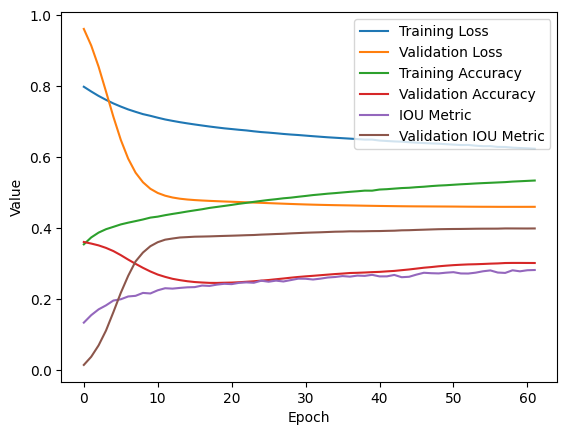

In [20]:
import matplotlib.pyplot as plt

# Plot the learning curves
plt.plot(history3.history['loss'], label='Training Loss')
plt.plot(history3.history['val_loss'], label='Validation Loss')
plt.plot(history3.history['accuracy'], label='Training Accuracy')
plt.plot(history3.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history3.history['iou_metric'], label='IOU Metric')
plt.plot(history3.history['val_iou_metric'], label='Validation IOU Metric')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.show()


In [21]:
# Make predictions on test data
predictions3 = model3.predict(test_images)

6/6 [==============================] - 22s 3s/step


In [22]:
# Calculate the average of values for all images
average_value3 = np.mean(predictions3)

# Print the average value
print("Average Value:", average_value3)

Average Value: 0.249509


1/1 [==============================] - 0s 183ms/step


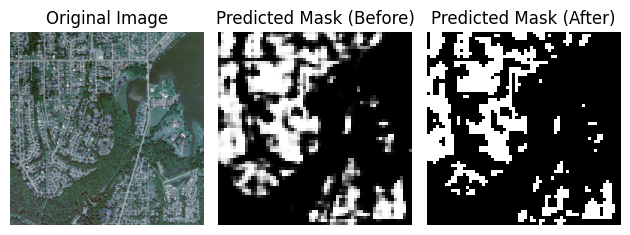

Minimum Value: 2.9455728e-07
Maximum Value: 0.9999995


In [23]:
import random
import matplotlib.pyplot as plt

# Select a random image index
image_index = random.randint(0, len(test_images) - 1)

# Get the corresponding test image and make a prediction
test_image = test_images[image_index]
prediction3 = model3.predict(np.expand_dims(test_image, axis=0))

# Reshape the prediction to remove the batch dimension
prediction3 = np.squeeze(prediction3)

# Calculate the minimum and maximum values of the prediction
min_value = np.min(prediction3)
max_value = np.max(prediction3)

# Apply threshold to convert to binary mask
threshold = 0.7  # Adjust the threshold value as needed
binary_mask3 = (prediction3 >= threshold).astype('float32')

# Plot the original image
plt.subplot(1, 3, 1)
plt.imshow(test_image)
plt.title("Original Image")
plt.axis("off")

# Plot the predicted mask
plt.subplot(1, 3, 2)
plt.imshow(prediction3, cmap='gray')
plt.title("Predicted Mask (Before)")
plt.axis("off")

# Plot the binary mask after applying threshold
plt.subplot(1, 3, 3)
plt.imshow(binary_mask3, cmap='gray')
plt.title("Predicted Mask (After)")
plt.axis("off")

plt.tight_layout()
plt.show()


# Display the minimum and maximum values of the prediction
print("Minimum Value:", min_value)
print("Maximum Value:", max_value)

In [10]:
import os
import cv2
import numpy as np

# Define the path to the equalized images directory
equalized_images_path = 'AerialImageDataset/equalized_images/train_resized_eq/'

# Define the list of areas
areas = ['austin', 'chicago', 'kitsap', 'tyrol-w', 'vienna']

# Lists to store the images and masks
images_eq = []
masks = []

# Loop over each area
for area in areas:
    # Get the path to the current area
    area_path = os.path.join(equalized_images_path, area)
    
    # Loop over the files in the area directory
    for filename in os.listdir(area_path):
        # Load the image
        image_path = os.path.join(area_path, filename)
        image = cv2.imread(image_path)
        
        # Preprocess the image if needed (e.g., normalization)
        image = img_to_array(image) / 255.0
        
        # Add the preprocessed image to the list
        images_eq.append(image)
        
        # # Load the corresponding mask
        # mask_filename = filename.replace('.tif', '_mask.gif')
        # mask_path = os.path.join(equalized_images_path, area, mask_filename)
        # mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        
        # # Preprocess the mask if needed (e.g., thresholding)
        # # ...
        
        # # Add the preprocessed mask to the list
        # masks.append(mask)

# Convert the image and mask lists to NumPy arrays
images_eq = np.array(images_eq)
# masks = np.array(masks)


In [11]:
# Create an instance of the UNet model
model4 = UNet3()
model4.build_model().summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 tf.image.resize_5 (TFOpLambda)  (None, 256, 256, 3)  0          ['input_8[0][0]']                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 256, 256, 64  1792        ['tf.image.resize_5[0][0]']      
                                )                                                                 
                                                                                            

In [12]:
# Train the model
model4.train(images_eq, resized_train_masks, epochs=100, batch_size=100, validation_split=0.1, verbose=1)


Epoch 1/100
2/2 [==============================] - 27s 12s/step - loss: 0.8022 - accuracy: 0.3456 - mean_io_u: 0.4888 - val_loss: 0.5824 - val_accuracy: 0.1198 - val_mean_io_u: 0.4850 - lr: 1.0000e-04
Epoch 2/100
2/2 [==============================] - 26s 11s/step - loss: 0.7996 - accuracy: 0.3550 - mean_io_u: 0.4888 - val_loss: 0.5815 - val_accuracy: 0.1151 - val_mean_io_u: 0.4856 - lr: 1.0000e-04
Epoch 3/100
2/2 [==============================] - 26s 12s/step - loss: 0.7972 - accuracy: 0.3620 - mean_io_u: 0.4888 - val_loss: 0.5811 - val_accuracy: 0.1133 - val_mean_io_u: 0.4860 - lr: 1.0000e-04
Epoch 4/100
2/2 [==============================] - 25s 11s/step - loss: 0.7951 - accuracy: 0.3669 - mean_io_u: 0.4888 - val_loss: 0.5809 - val_accuracy: 0.1115 - val_mean_io_u: 0.4858 - lr: 1.0000e-04
Epoch 5/100
2/2 [==============================] - 25s 11s/step - loss: 0.7932 - accuracy: 0.3712 - mean_io_u: 0.4888 - val_loss: 0.5812 - val_accuracy: 0.1104 - val_mean_io_u: 0.4858 - lr: 1.0000

In [13]:
# Make predictions on test data
predictions4 = model4.predict(test_images)

6/6 [==============================] - 20s 3s/step


In [14]:
# Calculate the average of values for all images
average_value4 = np.mean(predictions4)

# Print the average value
print("Average Value:", average_value4)

Average Value: 0.480718


1/1 [==============================] - 0s 155ms/step


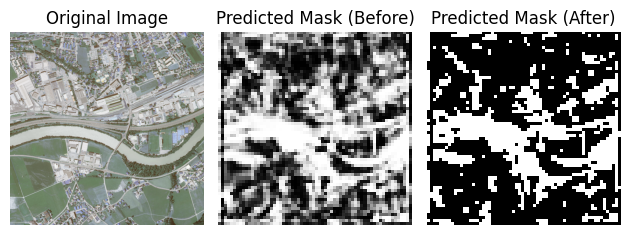

Minimum Value: 0.00016446781
Maximum Value: 0.9999961


In [21]:
import random
import matplotlib.pyplot as plt

# Select a random image index
image_index = random.randint(0, len(test_images) - 1)

# Get the corresponding test image and make a prediction
test_image = test_images[image_index]
prediction4 = model4.predict(np.expand_dims(test_image, axis=0))

# Reshape the prediction to remove the batch dimension
prediction4 = np.squeeze(prediction4)

# Calculate the minimum and maximum values of the prediction
min_value = np.min(prediction4)
max_value = np.max(prediction4)

# Apply threshold to convert to binary mask
threshold = 0.8  # Adjust the threshold value as needed
binary_mask4 = (prediction4 >= threshold).astype('float32')

# Plot the original image
plt.subplot(1, 3, 1)
plt.imshow(test_image)
plt.title("Original Image")
plt.axis("off")

# Plot the predicted mask
plt.subplot(1, 3, 2)
plt.imshow(prediction4, cmap='gray')
plt.title("Predicted Mask (Before)")
plt.axis("off")

# Plot the binary mask after applying threshold
plt.subplot(1, 3, 3)
plt.imshow(binary_mask4, cmap='gray')
plt.title("Predicted Mask (After)")
plt.axis("off")

plt.tight_layout()
plt.show()


# Display the minimum and maximum values of the prediction
print("Minimum Value:", min_value)
print("Maximum Value:", max_value)

In [78]:
# import cv2
# import numpy as np

# # Define the threshold
# threshold = 0.5

# # Iterate over the predicted masks
# for i in range(len(prediction2)):
#     # Apply thresholding to obtain binary mask
#     binary_mask2 = np.where(prediction2[i] > threshold, 1, 0).astype(np.uint8)

#     # Find contours in the binary mask
#     contours, hierarchy = cv2.findContours(binary_mask2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

#     # Draw contours on the original image with black outline
#     original_image_with_contours = np.copy(test_images[i])
#     cv2.drawContours(original_image_with_contours, contours, -1, (0, 0, 0), 1)

#     # Display the image with contours
#     cv2.imshow('Image with Contours', original_image_with_contours)
#     cv2.waitKey(0)
#     cv2.destroyAllWindows()


: 

: 

In [53]:
# import matplotlib.pyplot as plt

# # Select an index of the test image to visualize
# index = 0

# # Obtain the test image and its corresponding binary mask prediction
# test_image = test_images[index]
# binary_mask = binary_masks[index]

# # Plot the test image and binary mask side by side
# fig, axes = plt.subplots(1, 2, figsize=(10, 5))
# axes[0].imshow(test_image)
# axes[0].set_title('Test Image')
# axes[0].axis('off')

# axes[1].imshow(binary_mask.squeeze(), cmap='gray')
# axes[1].set_title('Binary Mask Prediction')
# axes[1].axis('off')

# plt.tight_layout()
# plt.show()
